In [2]:
# 自动计算cell的计算时间
%load_ext autotime

%config InlineBackend.figure_format='svg' #矢量图设置，让绘图更清晰

time: 6.55 ms (started: 2021-08-07 21:58:10 +08:00)


In [1]:
%%bash

# 增加更新
git add *.ipynb

git remote -v

git commit -m '更新 ch12 #4 change Aug 07, 2021'

git push origin master

origin	git@github.com:ustchope/dlwpn.git (fetch)
origin	git@github.com:ustchope/dlwpn.git (push)
[master 75de455] 更新 ch12 #4 change Aug 07, 2021
 1 file changed, 346 insertions(+), 230 deletions(-)


To github.com:ustchope/dlwpn.git
   3739155..75de455  master -> master


In [3]:
#设置使用的gpu
import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")

if gpus:
   
    gpu0 = gpus[0] #如果有多个GPU，仅使用第0个GPU
    tf.config.experimental.set_memory_growth(gpu0, True) #设置GPU显存用量按需使用
    # 或者也可以设置GPU显存为固定使用量(例如：4G)
    #tf.config.experimental.set_virtual_device_configuration(gpu0,
    #    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) 
    tf.config.set_visible_devices([gpu0],"GPU") 

time: 3.81 s (started: 2021-08-07 21:58:12 +08:00)


# 生成式深度学习

**本章包含**

* 文本生成
* DeepDream
* 神经风格迁移
* 变分自编码器
* 生成对抗网络

人工智能模拟人类思维过程的潜力超越了被动任务（如物体识别）和主要反应性任务（如驾驶汽车）。它很好地扩展到创造性活动中。当我第一次声称在不久的将来，我们消费的大部分文化内容都将在 AI 的大力帮助下创建时，我完全不相信，即使是长期从事机器学习的从业者也是如此。那是在 2014 年。快进三年，怀疑已经消退 - 以令人难以置信的速度。 2015 年夏天，我们被 Google 的 DeepDream 算法逗乐了，该算法将图像变成迷幻的狗眼和幻觉伪像； 2016 年，我们使用 Prisma 应用程序将照片变成各种风格的画作。 2016年夏天，一部实验性短片《太阳之泉》使用长短期记忆编写的剧本进行导演，并配上对白。也许您最近听过由神经网络临时生成的音乐。

诚然，到目前为止，我们从 AI 看到的艺术作品质量相当低。 人工智能远不能与人类编剧、画家和作曲家匹敌。 但取代人类总是无关紧要：人工智能不是用其他东西取代我们自己的智能，而是将智能——一种更不同的智能——带入我们的生活和工作。 在许多领域，尤其是在创意领域，人工智能将被人类用作增强自身能力的工具：比人工智能更多的增强智能。

艺术创作的很大一部分包括简单的模式识别和技术技能。而这正是许多人认为不那么有吸引力甚至可有可无的过程的一部分。这就是人工智能的用武之地。我们的感知方式、我们的语言和我们的艺术作品都有统计结构。学习这种结构是深度学习算法所擅长的。机器学习模型可以学习图像、音乐和故事的统计潜在空间，然后他们可以从这个空间中采样，创造出与模型在训练数据中看到的特征相似的新艺术作品。当然，这种采样本身并不是一种艺术创作行为。这仅仅是一个数学运算：该算法没有人类生活、人类情感或我们对世界的经验的基础；相反，它从与我们几乎没有共同之处的经验中学习。只有我们作为人类旁观者的解释才能赋予模型生成的意义。但在熟练的艺术家手中，算法生成可以被引导变得有意义和美丽。潜在空间采样可以成为赋予艺术家权力的画笔，增强我们的创造力，并扩展我们可以想象的空间。更重要的是，它可以通过消除对技术技能和实践的需求来使艺术创作更容易获得——建立一种新的纯粹表达媒介，将艺术与工艺分开。

Iannis Xenakis 是电子和算法音乐的有远见的先驱，在 1960 年代，在自动化技术应用于音乐创作的背景下，他精美地表达了同样的想法：

> 从繁琐的计算中解脱出来，作曲家能够致力于解决新音乐形式带来的一般问题，并在修改输入数据值的同时探索这种形式的角落和缝隙。 例如，他可能会测试从独奏家到室内管弦乐队，再到大型管弦乐队的所有乐器组合。 在电子计算机的帮助下，作曲家变成了一种飞行员：他按下按钮，输入坐标，并监督宇宙飞船在声音空间中航行的控制，穿越声波星座和星系，他以前只能通过 遥远的梦。

在本章中，我们将从各个角度探讨深度学习在增强艺术创作方面的潜力。 我们将回顾使用变分自动编码器和生成对抗网络的序列数据生成（可用于生成文本或音乐）、DeepDream 和图像生成。 我们会让您的计算机梦想出前所未有的内容； 也许我们也会让您梦想技术与艺术的交汇处的奇妙可能性。 让我们开始吧。

## 文本生成

在本节中，我们将探讨如何使用循环神经网络来生成序列数据。 我们将使用文本生成作为示例，但完全相同的技术可以推广到任何类型的序列数据：您可以将其应用于音符序列以生成新音乐，以及笔触数据的时间序列（例如， 艺术家在 iPad 上绘画时录制）以逐笔生成绘画，依此类推。

序列数据生成绝不仅限于艺术内容生成。 它已成功应用于语音合成和聊天机器人的对话生成。 谷歌于 2016 年发布的智能回复功能，能够自动生成一系列对电子邮件或短信的快速回复，由类似技术提供支持。

### 序列生成的生成式深度学习简史

2014 年底，即使在机器学习社区中，也很少有人见过 LSTM 的缩写。使用循环网络生成序列数据的成功应用直到 2016 年才开始出现在主流中。但是这些技术有着相当长的历史，从 1997 年 LSTM 算法的发展开始。这种新算法很早就被用来逐个字符地生成文本。

2002 年，当时在瑞士 Schmidhuber 实验室的 Douglas Eck 首次将 LSTM 应用于音乐生成，并取得了可喜的成果。Eck 现在是 Google Brain 的一名研究员，2016 年他在那里成立了一个名为 Magenta 的新研究小组，专注于应用现代深度学习技术来制作引人入胜的音乐。 有时，好的想法需要 15 年才能开始。

在 2000 年代末和 2010 年代初，Alex Graves 在使用循环网络生成序列数据方面做了重要的开创性工作。特别是，他在 2013 年应用循环混合密度网络使用笔位置的时间序列生成类似人类的笔迹的工作被一些人视为一个转折点。神经网络在那个特定时刻的这种特定应用让我想起了做梦的机器的概念，并且在我开始开发 Keras 时给了我很大的启发。格雷夫斯在 2013 年上传到预印服务器 arXiv 的 LaTeX 文件中留下了类似的注释掉的评论：“生成顺序数据是最接近梦想的计算机。”几年后，我们认为很多这些发展是理所当然的。但在当时，很难看到 Graves 的演示，也很难不因各种可能性而敬畏地走开。 2015 年至 2017 年间，循环神经网络成功用于文本和对话生成、音乐生成和语音合成。

然后在 2017-2018 年左右，Transformer 架构开始接管循环神经网络，不仅用于有监督的自然语言处理任务，还用于生成序列模型——特别是语言建模、词级文本生成。 生成式 Transformer 最著名的例子是 GPT-3，这是一个 1750 亿参数的文本生成模型，由初创公司 OpenAI 在一个惊人的大文本语料库上训练——包括大多数数字可用的书籍、维基百科和大部分爬行 整个互联网。 GPT-3 成为 2020 年的头条新闻，因为它能够为几乎任何主题生成听起来似乎合理的文本段落，这种能力已经引发了短暂的炒作浪潮，值得最火热的 AI 夏季。

### 如何生成序列数据？

在深度学习中生成序列数据的通用方法是训练模型（通常是 Transformer 或 RNN）来预测序列中的下一个标记或接下来的几个标记，使用之前的标记作为输入。 例如，给定输入“the cat is on the”，模型被训练以预测目标“mat”，即下一个单词。 与处理文本数据时一样，标记通常是单词或字符，任何可以对给定前一个标记的下一个标记的概率进行建模的网络称为语言模型。 语言模型捕捉语言的潜在空间：它的统计结构。

一旦你有了这样一个训练有素的语言模型，你就可以从中（生成新的序列）：采样你给它一个初始文本字符串（称为条件数据），让它生成下一个字符或下一个单词（你甚至可以生成 多个标记一次），将生成的输出添加回输入数据，并多次重复该过程（见图 12.1）。 此循环允许您生成任意长度的序列，以反映模型训练所依据的数据结构：看起来像人工编写的句子的序列。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt6xmu3nppj31860kc76q.jpg)

### 采样策略的重要性

生成文本时，选择下一个标记的方式至关重要。 一种天真的方法是贪婪采样，包括始终选择最可能的下一个字符。 但是这种方法会导致重复的、可预测的字符串看起来不像连贯的语言。 一种更有趣的方法做出了更令人惊讶的选择：它通过从下一个字符的概率分布中采样，在采样过程中引入了随机性。 这称为随机抽样（回想一下，随机性就是我们在该领域所说的随机性）。 在这样的设置中，如果一个词出现在句子中的下一个的概率为 0.3，根据模型，您将有 30% 的时间选择它。 请注意，贪婪抽样也可以转换为从概率分布中抽样：某个单词的概率为 1，所有其他单词的概率为 0。

从模型的 softmax 输出中进行概率采样很巧妙：它甚至可以在某些时候对不太可能的单词进行采样，从而生成看起来更有趣的句子，有时还可以通过想出没有出现过的新的、听起来真实的句子来展示创造力 在训练数据中。 但是这种策略有一个问题：它没有提供一种方法来控制采样过程中的随机性。

为什么你想要更多或更少的随机性？考虑一个极端情况：纯随机抽样，您从均匀概率分布中抽取下一个单词，并且每个单词的可能性相同。该方案具有最大的随机性；换句话说，这个概率分布具有最大的熵。自然，它不会产生任何有趣的东西。在另一个极端，贪婪采样也不会产生任何有趣的东西，并且没有随机性：相应的概率分布具有最小的熵。从“真实”概率分布（模型的 softmax 函数输出的分布）中采样构成了这两个极端之间的中间点。但是，您可能还想探索许多其他具有较高或较低熵的中间点。更少的熵将使生成的序列具有更可预测的结构（因此它们可能看起来更逼真），而更多的熵将导致更令人惊讶和创造性的序列。从生成模型中采样时，探索生成过程中不同数量的随机性总是好的。因为我们——人类——是生成数据有趣程度的最终判断者，有趣程度是高度主观的，并且无法提前知道最佳熵的点在哪里。

为了控制采样过程中的随机性，我们将引入一个称为 softmax 温度的参数，它表征用于采样的概率分布的熵：它表征下一个词的选择将是多么令人惊讶或可预测。 给定一个温度值，根据原始概率分布（模型的 softmax 输出）计算新的概率分布，方法是按以下方式对其进行重新加权。

> 清单 12.1 将概率分布重新加权到不同的温度

In [10]:
import numpy as np


# original_distribution 是一维 NumPy 概率值数组，其总和必须为 1。温度是量化输出分布熵的一个因素。
def reweight_distribution(original_distribution, temperature=0.5): 
    distribution = np.log(original_distribution) / temperature
    distribution = np.exp(distribution)
    # 返回原始发行版的重新加权版本。 分布的总和可能不再是 1，因此您将其除以总和以获得新的分布。
    return distribution / np.sum(distribution)

time: 982 µs (started: 2021-08-06 12:21:58 +08:00)


更高的温度会导致更高熵的采样分布，这将生成更令人惊讶和非结构化的生成数据，而更低的温度将导致更少的随机性和更可预测的生成数据（见图 12.2）。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt6ye63yw5j310c0ny40v.jpg)

### 使用 Keras 实现文本生成

让我们在 Keras 实现中将这些想法付诸实践。 您首先需要的是大量可用于学习语言模型的文本数据。 您可以使用任何足够大的文本文件或文本文件集——维基百科、指环王等。

在这个例子中，我们将继续使用上一章的 IMDB 电影评论数据集，我们将学习生成从未阅读过的电影评论。 因此，我们的语言模型将是这些电影评论的风格和主题的模型，而不是英语语言的通用模型。

**准备数据**

和上一章一样，让我们下载并解压 IMDB 影评数据集：

> 清单 12.2 下载并解压 IMDB 电影评论数据集

In [ ]:
# !wget https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
# !tar -xf aclImdb_v1.tar.gz

您已经熟悉数据的结构：我们得到一个名为 aclImdb 的文件夹，其中包含两个子文件夹，一个用于负面情绪的电影评论，一个用于正面情绪的评论。 每条评论有一个文本文件。 我们将使用 label_mode=None 调用 text_dataset_from_directory 来创建一个数据集，该数据集从这些文件中读取并生成每个文件的文本内容。

> 清单 12.3 创建一个产生一组文本文件内容的数据集（一个文件=一个样本）

In [4]:
import tensorflow as tf
from tensorflow import keras

dataset = keras.preprocessing.text_dataset_from_directory(directory="data/aclImdb", 
                                                          label_mode=None, 
                                                          batch_size=256)

dataset = dataset.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 50006 files belonging to 1 classes.
time: 5.38 s (started: 2021-08-06 12:52:07 +08:00)


In [17]:
cd /public/huangwei/test/deep-learning-with-python-notebooks/

/public/huangwei/test/deep-learning-with-python-notebooks
time: 9.66 ms (started: 2021-08-06 12:50:01 +08:00)


去掉许多评论中出现的 `HTML` 标签。 这对于文本分类来说无关紧要`<br />`，但我们不想在这个 `<br />` 示例中生成标签！

现在，让我们使用 TextVectorization 层来计算我们将使用的词汇表。 我们将只使用每个评论的第一个 sequence_length 词：我们的 TextVectorization 层将在矢量化文本时切断除此之外的任何内容。

> 清单 12.4 准备一个 TextVectorization 层

In [6]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# 我们只会考虑前 15,000 个最常用的词——其他任何词都将被视为词汇外标记“[UNK]”。
sequence_length = 100
vocab_size = 15000 
text_vectorization = TextVectorization(max_tokens=vocab_size, 
                                       # 我们想要返回整数词索引序列。
                                       output_mode="int", 
                # 我们将使用长度为 100 的输入和目标（但由于我们将目标偏移 1，模型实际上将看到长度为 99 的序列）。
                                       output_sequence_length=sequence_length,)

text_vectorization.adapt(dataset)

time: 13.2 s (started: 2021-08-06 12:56:56 +08:00)


> 清单 12.5 设置语言建模数据集

In [7]:
def prepare_lm_dataset(text_batch):
#     将一批文本（字符串）转换为一批整数序列
    vectorized_sequences = text_vectorization(text_batch) 
#     通过切断序列的最后一个字来创建输入
    x = vectorized_sequences[:, :-1] 
#     通过将序列偏移 1 来创建目标
    y = vectorized_sequences[:, 1:] 
    return x, y

lm_dataset = dataset.map(prepare_lm_dataset)
# 为了获得更好的性能，请确保始终在内存中预取 8 个批次
lm_dataset = lm_dataset.prefetch(8)

time: 263 ms (started: 2021-08-06 13:00:23 +08:00)


**基于变压器的序列到序列模型**

我们将训练一个模型来预测句子中下一个词的概率分布，给定一些初始词。 当模型训练好后，我们会给它一个提示，我们将对下一个单词进行采样，然后将该单词添加回提示中，然后重复，直到我们生成一个短段落。

与我们在第 10 章中为温度预测所做的类似，我们可以训练一个模型，将 N 个单词的序列作为输入并简单地预测单词 N+1。 但是，在序列生成的上下文中，此设置存在几个问题。

首先，该模型只会学习在给定 N 个可用单词的情况下生成预测，但是能够以少于 N 个单词开始预测会很有用。 否则，我们将被限制为仅使用相对较长的提示（在我们的实现中，N=100 字）。 我们在第 10 章中没有这个需求。

其次，我们的许多训练序列将大部分重叠。 考虑 N = 4：文本“一个完整的句子必须至少包含三件事：主语、动词和宾语”将用于生成以下训练序列：
* “一个完整的句子必须”
* “完整的句子必须有”
* “句子必须在”
* 依此类推，直到“动词和对象”。

将每个这样的序列视为独立样本的模型将不得不做大量冗余工作，因为必须重新编码它以前主要见过的多次子序列。 在第 10 章中，这不是什么大问题，因为我们一开始没有那么多训练样本，而且我们需要对密集和卷积模型进行基准测试，为此，每次重新做工作是唯一的 选项。 我们可以尝试通过使用步幅对我们的序列进行采样来缓解这种冗余问题——在两个连续的样本之间跳过几个单词。 但它会减少我们的训练样本量，同时只能提供部分解决方案。

为了解决这两个问题，我们将使用序列到序列模型：我们将 N 个单词的序列（索引从 0 到 N）输入我们的模型，我们将预测序列偏移一（从 1 到 N+1）。 我们将使用因果掩码来确保对于任何 i，模型将仅使用从 0 到 i 的单词来预测单词 i+1。 这意味着我们同时训练模型来解决大部分重叠但不同的问题：在给定 1 i N 个先前单词的序列中预测下一个单词（见图 12.3）。 在生成时，即使你只用一个词提示模型，它也能给出下一个可能词的概率分布。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt6zla02t0j31h60p677j.jpg)

请注意，我们可以在第 10 章的温度预测问题上使用类似的序列到序列设置：给定 120 个每小时数据点的序列，学习生成 120 个在未来 24 小时内偏移的温度序列。 你不仅要解决最初的问题，还要解决 24 小时内预测温度的 119 个相关问题，给定 1 i < 120 个先前的每小时数据点。 如果您尝试在序列到序列设置中重新训练第 10 章中的 RNN，您会发现您得到相似但逐渐变差的结果，因为使用相同模型解决这些额外的 119 个相关问题的约束会略微干扰 我们真正关心的任务。

在前一章中，您已经了解了在一般情况下可用于序列到序列学习的设置：将源序列输入编码器，然后将编码序列和目标序列输入解码器 预测相同的目标序列偏移一步。 当你在做文本生成时，没有源序列：你只是想在给定过去的标记的情况下预测目标序列中的下一个标记，我们只能使用解码器来做到这一点。 并且由于因果填充，解码器将只查看单词 0…N 来预测单词 。

让我们实现我们的模型——我们将重用我们在第 11 章中创建的构建块：PositionalEmbedding 和 TransformerDecoder。

> 清单 12.6 一个简单的基于 Transformer 的语言模型

In [8]:
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)

# Softmax 在可能的词汇词上，为每个输出序列时间步长计算
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop")

NameError: name 'PositionalEmbedding' is not defined

time: 2.31 s (started: 2021-08-06 13:10:03 +08:00)


### 具有可变温度采样的文本生成回调

我们将使用回调在每个时期之后使用一系列不同的温度生成文本。 这使您可以看到生成的文本如何随着模型开始收敛而演变，以及温度对采样策略的影响。 要生成文本的种子，我们将使用提示“这部电影”：我们生成的所有文本都将以此开头。

> 清单 12.7 文本生成回调

In [ ]:
import numpy as np

# 将单词索引映射回字符串的字典，用于文本解码。
tokens_index = dict(enumerate(text_vectorization.get_vocabulary())) 


# 从概率分布中实现可变温度采样。
def sample_next(predictions, temperature=1.0): 
    predictions = np.asarray(predictions).astype("float64")
    predictions = np.log(predictions) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

class TextGenerator(keras.callbacks.Callback):
    def __init__(self, prompt, generate_length, model_input_length, temperatures=(1.,), print_freq=1):
        # 我们用来生成文本种子的矢量化提示。
        self.prompt = prompt
        # 要生成多少字。
        self.generate_length = generate_length
        self.model_input_length = model_input_length
        # 用于采样的温度范围。
        self.temperatures = temperatures
        self.print_freq = print_freq
    
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.print_freq != 0:
            return
        for temperature in self.temperatures:
            print("== Generating with temperature", temperature)
            # 生成文本时，我们从提示开始。
            sentence = self.prompt 
            for i in range(self.generate_length):
                # 将当前序列输入到我们的模型中。
                tokenized_sentence = text_vectorization([sentence]) 
                predictions = self.model(tokenized_sentence)
                # 检索最后一个时间步的预测并使用它们来采样一个新词
                next_token = sample_next(predictions[0, i, :]) 
                sampled_token = tokens_index[next_token] 
#                 将新单词附加到当前序列并重复。
                sentence += " " + sampled_token
            print(sentence)


prompt = "This movie"
text_gen_callback = TextGenerator(prompt,
                                  generate_length=50,
                                  model_input_length=sequence_length,
#                                   我们将使用不同范围的温度对文本进行采样，以演示温度对文本生成的影响。
                                  temperatures=(0.2, 0.5, 0.7, 1., 1.5))

让我们 fit() 这个东西：

> 清单 12.8 拟合语言模型

In [ ]:
model.fit(lm_dataset, epochs=200, callbacks=[text_gen_callback])

以下是我们经过 200 次训练后能够生成的一些精心挑选的示例。 请注意，标点符号不是我们词汇表的一部分，因此我们生成的文本都没有任何标点符号。

* 温度=0.2：
    - “这部电影是原版电影的 [UNK]，电影的前半小时很不错，但它是一部非常好的电影，是该时期的一部好电影”
    - “这部电影是电影的 [UNK] 这是一部非常糟糕的电影，它是一部 [UNK] 电影 这是一部非常糟糕的电影，它让你在笑和哭的同时，它不是一部 我想我从未看过的电影”
* 温度=0.5：
    - “这部电影是 [UNK] 有史以来最好的类型电影，它不是一部好电影，这是我第一次看到这部电影的唯一优点，我仍然记得它是 [UNK] 我看了很多年的电影”
    - “这部电影是浪费时间和金钱我不得不说这部电影完全是浪费时间我很惊讶地看到这部电影是由一部好电影组成的电影不是很好但它是浪费 时间和”
* 温度=0.7：
    - “这部电影很有趣，看着所有的角色都非常搞笑，而且猫有点像 [UNK] [UNK] 和一顶帽子 [UNK] 电影的规则可以在另一个中讲述 场景将其从“
    - “这部电影是关于 [UNK] 和几个年轻人在一条小船上在偏僻的地方人们可能会发现自己接触到 [UNK] 牙医他们被 [UNK] 杀死了我是这个的忠实粉丝 书，我还没有看过原版，所以它”
* 温度=1.0：
    - “这部电影很有趣，我觉得情节线很响亮而且很感人，但从整体上看，与原作的艺术形成鲜明对比，我们观看了英国的原始版本，然而弧线有点太普通了 [UNK] 是现在的父母 [UNK]”
    - “这部电影是远离故事情节的杰作，但这部电影只是令人兴奋和令人沮丧，它真的让这样的朋友开心，这部电影中的演员试图直接从画面中走出来，他们使它成为一个非常好的电视节目”
* 温度=1.5：
    - “这部电影可能是关于那 80 位女性的最糟糕的电影，它是像巴克电影一样奇怪的有见地的演员，但在好朋友中是的，即使 [UNK] 陆地恐龙 ralph ian 也没有装饰过的盾牌，必须制作一部戏发生在错误的 [UNK] bach 之后 真的不是摔跤狂热，山姆根本不存在”
    - “这部电影可能是如此令人难以置信，卢卡斯本人为我们的国家带来了非常有趣的事情，因为科林的严肃而有力的表演更加详细，但在此之前，图像齿轮燃烧着爱国主义我们你期望戴恩老板的奉献必须做你自己的 职责和另一个”

如您所见，较低的温度值会导致非常无聊和重复的文本，有时会导致生成过程陷入循环。 随着温度的升高，生成的文本变得更有趣、更令人惊讶，甚至更有创意。 在非常高的温度下，局部结构开始分解，输出看起来基本上是随机的。 在这里，一个好的生成温度似乎是 0.7 左右。 始终尝试多种采样策略！ 学习结构和随机性之间的巧妙平衡使生成变得有趣。

请注意，通过训练更大、更长、更多数据的模型，您可以获得看起来比这个模型更加连贯和真实的生成样本——像 GPT-3 这样的模型的输出是一个很好的例子，说明可以用语言完成什么 模型（GPT-3 实际上与我们上面训练的相同，但是有很深的 Transformer 解码器堆栈和更大的训练语料库）。 但是，当然，不要期望生成任何有意义的文本，除非通过随机机会和您自己解释的魔力：您所做的只是从统计模型中采样数据，了解哪些词出现在哪些词之后。 语言模型都是形式，没有实质。

自然语言有很多东西：一种沟通渠道，一种对世界采取行动的方式，一种社会润滑剂，一种制定、存储和检索自己思想的方式……语言的这些用途是其意义的来源。一个深度学习“语言模型”，尽管有它的名字，但实际上没有捕捉到语言的这些基本方面。它不能交流（它没有任何东西可以交流，也没有人可以与之交流），它不能对世界采取行动（它没有代理，也没有意图），它不能社交，也没有任何想法可以处理文字的帮助。语言是大脑的操作系统，因此，要使语言有意义，就需要大脑来利用它。

语言模型的作用是捕获可观察的工件（书籍、在线电影评论、推文）的统计结构，这些是我们在使用语言来过我们的生活时生成的。这些工件完全具有统计结构的事实是人类如何实现语言的副作用。这是一个思想实验：如果我们的语言在压缩通信方面做得更好，就像计算机对大多数数字通信所做的那样，会怎样？语言同样具有意义，仍然可以实现它的许多目的，但它缺乏任何内在的统计结构，因此无法像刚才那样建模。

### 总结

* 您可以通过训练模型来预测下一个标记（给定先前的标记）来生成离散序列数据。
* 在文本的情况下，这样的模型称为语言模型。 它可以基于单词或字符。
* 采样下一个令牌需要在坚持模型判断的可能性和引入随机性之间取得平衡。
* 处理这个问题的一种方法是 softmax 温度的概念。 始终尝试不同的温度以找到合适的温度。

## DeepDream

DeepDream 是一种艺术图像修改技术，它使用卷积神经网络学习的表征。 它于 2015 年夏天由 Google 首次发布，作为使用 Caffe 深度学习库编写的实现（这是 TensorFlow 首次公开发布的几个月前）。 由于它可以生成的迷幻图片（例如，参见图 12.4），充满了算法伪影、鸟羽和狗眼——这是 DeepDream convnet 在 ImageNet 上训练的副产品 ，其中狗的品种和鸟类的数量过多。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt721amobzj30y20pytjq.jpg)

DeepDream 算法几乎与第 9 章中介绍的 convnet 过滤器可视化技术相同，包括反向运行 convnet：对 convnet 的输入进行梯度上升，以最大限度地激活上层特定过滤器 网络。 DeepDream 使用了相同的想法，但有一些简单的区别：
* 使用 DeepDream，您尝试最大化整个层的激活而不是特定过滤器的激活，从而一次将大量特征的可视化混合在一起。
* 你不是从空白的、稍微嘈杂的输入开始，而是从现有的图像开始——因此产生的效果锁定在预先存在的视觉模式上，以一种有点艺术的方式扭曲图像的元素。
* 输入图像以不同的比例（称为 ）进行处理，这提高了可视化的八度音阶质量。

让我们做一些 DeepDreams。

### 在 Keras 中实现 DeepDream

让我们从检索一个用于梦想的测试图像开始。 我们将使用冬季崎岖的北加州海岸的景色。

442368/440742 [==============================] - 2s 5us/step


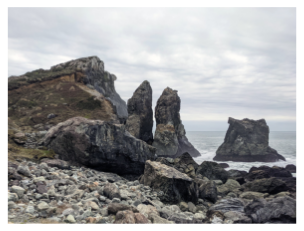

time: 4.07 s (started: 2021-08-06 14:34:17 +08:00)


In [10]:
from tensorflow import keras
import matplotlib.pyplot as plt

base_image_path = keras.utils.get_file("coast.jpg", 
                                       origin="https://img-datasets.s3.amazonaws.com/coast.jpg")
plt.axis("off")
plt.imshow(keras.preprocessing.image.load_img(base_image_path))

接下来，我们需要一个预训练的 convnet。 在 Keras 中，有许多这样的 convnets 可用：VGG16、VGG19、Xception、ResNet50 等，所有这些都具有在 ImageNet 上预训练的权重。 您可以使用它们中的任何一个来实现 DeepDream，但是您选择的基本模型自然会影响您的可视化，因为不同的架构会导致不同的学习特征。 在最初的 DeepDream 版本中使用的 convnet 是一个 Inception 模型，而在实践中，Inception 可以生成漂亮的 DeepDreams，因此您将使用 Keras 附带的 Inception V3 模型。

In [11]:
from tensorflow.keras.applications import inception_v3
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87916544/87910968 [==============================] - 100s 1us/step
time: 1min 48s (started: 2021-08-06 14:35:14 +08:00)


我们将使用我们的预训练 convnet 来创建一个特征精确器模型，该模型返回下面列出的各种中间层的激活。 对于每一层，我们选择一个标量分数，加权该层对我们将在梯度上升过程中寻求最大化的损失的贡献。 如果您想要一个完整的层名称列表来选择要使用的新层，只需使用 model.summary()。

In [12]:
# 我们尝试最大化激活的层的名称，以及它们在总损失中的权重。 您可以调整这些设置以获得新的视觉效果。
layer_settings = { 
 "mixed4": 1.0,
 "mixed5": 1.5,
 "mixed6": 2.0,
 "mixed7": 2.5,
}

# 每层的符号输出。
outputs_dict = dict( 
 [(layer.name, layer.output) for layer in [model.get_layer(name) for name in layer_settings.keys()]]
)

# 返回每个目标层的激活值的模型（作为字典）。
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

time: 55.1 ms (started: 2021-08-06 15:00:35 +08:00)


In [13]:
outputs_dict

{'mixed4': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed4')>,
 'mixed5': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>,
 'mixed6': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed6')>,
 'mixed7': <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed7')>}

time: 5.5 ms (started: 2021-08-06 15:00:40 +08:00)


In [14]:
feature_extractor.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [15]:
from tensorflow.keras.utils import plot_model

time: 1.14 ms (started: 2021-08-06 15:06:33 +08:00)


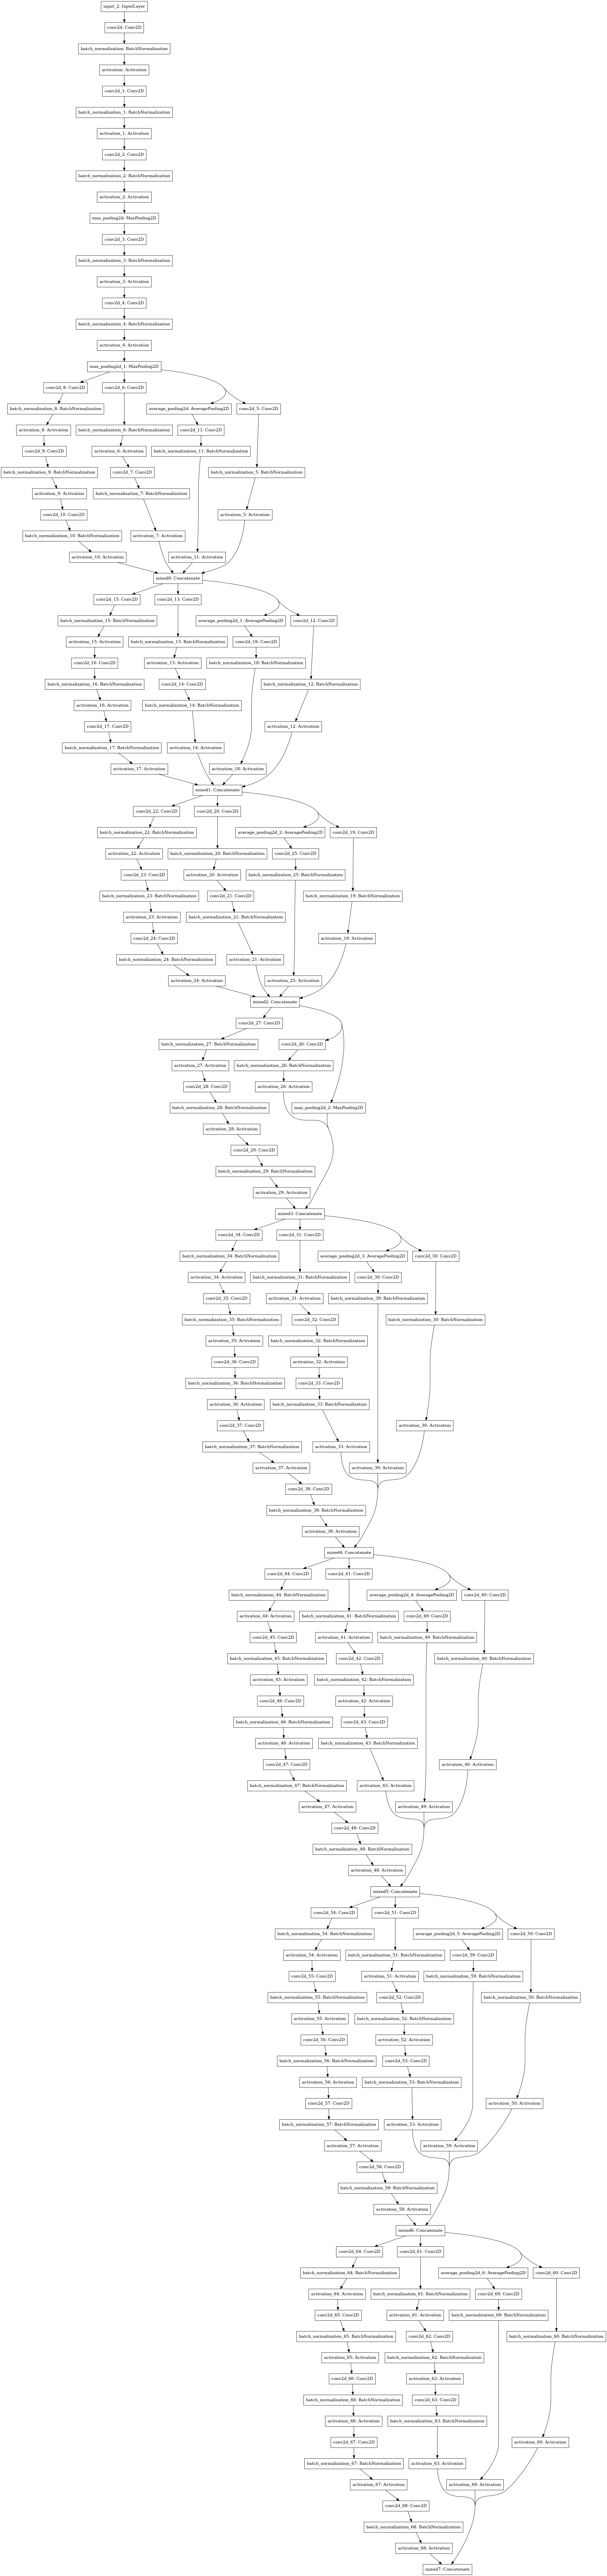

time: 4.36 s (started: 2021-08-06 15:07:00 +08:00)


In [16]:
plot_model(feature_extractor)

In [17]:
model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

接下来，您将计算 : 在每个处理规模的梯度上升损失过程中您将寻求最大化的数量。 在第 9 章中，对于过滤器可视化，您尝试最大化特定层中特定过滤器的值。 在这里，您将同时最大化多个层中所有过滤器的激活。 具体来说，您将最大化一组高级层的激活的 L2 范数的加权平均值。 您选择的确切层集（以及它们对最终损失的贡献）对您能够产生的视觉效果有重大影响，因此您希望使这些参数易于配置。 较低层产生几何图案，而较高层产生视觉效果，您可以在其中识别 ImageNet 中的某些类（例如，鸟或狗）。 您将从涉及四层的有点随意的配置开始——但您肯定会想在以后探索许多不同的配置。

In [18]:
def compute_loss(input_image):
#     提取激活
    features = feature_extractor(input_image) 
    # 将损失初始化为 0
    loss = tf.zeros(shape=()) 
    for name in features.keys():
        coeff = layer_settings[name]
        activation = features[name]
        # 我们通过仅在损失中涉及非边界像素来避免边界伪影。
        loss += coeff * tf.reduce_mean(tf.square(activation[:, 2:-2, 2:-2, :])) 
    return loss

time: 1.78 ms (started: 2021-08-06 15:11:22 +08:00)


现在，让我们设置我们将在每个八度音程运行的梯度上升过程。 您会发现它与第 9 章中的过滤器可视化技术相同！ DeepDream 算法只是过滤器可视化的多尺度形式。

In [19]:
import tensorflow as tf


# 我们通过将其编译为 tf.function 来加快训练步骤
@tf.function 
def gradient_ascent_step(image, learning_rate):
    # 计算 DeepDream 损失相对于当前图像的梯度。
    with tf.GradientTape() as tape:
        tape.watch(image)
        loss = compute_loss(image)
    grads = tape.gradient(loss, image) 
    
    # 归一化梯度（我们在第 9 章中使用的相同技巧）
    grads = tf.math.l2_normalize(grads) 
    image += learning_rate * grads
    return loss, image

# 这对给定的图像比例（八度）运行梯度上升
def gradient_ascent_loop(image, iterations, learning_rate, max_loss=None): 
    # 以增加 DeepDream 损失的方式重复更新图像
    for i in range(iterations):
        loss, image = gradient_ascent_step(image, learning_rate)
        # 如果损失超过某个阈值，则突破（过度优化会产生不需要的图像伪影）
        if max_loss is not None and loss > max_loss:
            break
        print(f"... Loss value at step {i}: {loss:.2f}")
    return image

time: 11.9 ms (started: 2021-08-06 15:16:06 +08:00)


最后：DeepDream 算法的外循环。 首先，我们定义处理图像的列表（也称为标度八度）。 每个连续的比例都比前一个大 1.4 倍（大 40%）：您首先处理一个小图像，然后逐渐放大（见图 12.6）。 我们将在 3 个不同的大小比例或“八度音阶”上处理我们的图像。 在每个八度音阶之间，我们将图像放大 40% (1.4x)：我们首先处理一个小图像，然后逐渐放大（见图 12.7）。 对于每个连续的尺度，从最小到最大，我们将通过 gradient_ascent_loop() 运行 20 个梯度上升步骤，以最大化我们之前定义的损失。 在每次梯度上升运行后，我们会将生成的图像放大 40%。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt73cjen35j31du0putea.jpg)

我们在下面定义这个过程的参数。 调整这些参数将使您获得新的效果！

In [23]:
# 梯度上升步长
step = 20.
# 运行梯度上升的尺度数
num_octave = 3
# 连续音阶之间的大小比例
octave_scale = 1.4 
# 每个尺度的梯度上升步数
iterations = 30
# 如果损失高于此值，我们将停止某个比例的梯度上升过程
max_loss = 15.

time: 1.53 ms (started: 2021-08-06 15:26:08 +08:00)


我们还需要一些实用函数来加载和保存图像：

In [20]:
import numpy as np

# Util 函数将图片打开、调整大小并将其格式化为适当的数组
def preprocess_image(image_path): 
    img = keras.preprocessing.image.load_img(image_path)
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.inception_v3.preprocess_input(img)
    return img

# 将 NumPy 数组转换为有效图像的 Util 函数
def deprocess_image(img): 
    img = img.reshape((img.shape[1], img.shape[2], 3))
    # 撤消初始 v3 预处理
    img /= 2.0 
    img += 0.5 
    img *= 255. 
    # 转换为 uint8 并剪辑到有效范围 [0, 255]
    img = np.clip(img, 0, 255).astype("uint8") 
    return img

time: 2.11 ms (started: 2021-08-06 15:22:10 +08:00)


这是实际的外循环。 一个重要的细节：为了避免在每次连续放大后丢失大量图像细节（导致图像越来越模糊或像素化），我们可以使用一个简单的技巧：在每次放大后，我们将丢失的细节重新注入 图像，这是可能的，因为我们知道原始图像在更大的比例下应该是什么样子。 给定一个较小的图像大小 S 和一个较大的图像大小 L，我们可以计算调整到大小 L 的原始图像和调整到大小 S 的原始图像之间的差异——这种差异量化了从 S 到 L 时丢失的细节。

In [25]:
# 加载测试图像
original_img = preprocess_image(base_image_path)
original_shape = original_img.shape[1:3]

# 计算不同八度的图像的目标形状
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape]) 
    successive_shapes.append(shape) 
successive_shapes = successive_shapes[::-1] 


shrunk_original_img = tf.image.resize(original_img, successive_shapes[0])

# 制作图像的副本（我们需要保留原件）
img = tf.identity(original_img) 

# 迭代不同的八度
for i, shape in enumerate(successive_shapes): 
    print(f"Processing octave {i} with shape {shape}")
    # 放大梦想的形象
    img = tf.image.resize(img, shape)
    # 跑梯度上升，改变梦想
    img = gradient_ascent_loop(img, iterations=iterations, learning_rate=step, max_loss=max_loss)
    # 放大原始图像的较小版本：它将被像素化。
    upscaled_shrunk_original_img = tf.image.resize(shrunk_original_img, shape) 
    # 计算此尺寸的原始图像的高质量版本
    same_size_original = tf.image.resize(original_img, shape) 
    # 两者之间的区别在于放大时丢失的细节。
    lost_detail = same_size_original - upscaled_shrunk_original_img 

    # 将丢失的细节重新注入梦中
    img += lost_detail 
    shrunk_original_img = tf.image.resize(original_img, shape)
    

# 保存最终结果
keras.preprocessing.image.save_img("dream.png", deprocess_image(img.numpy()))

Processing octave 0 with shape (459, 612)
... Loss value at step 0: 0.80
... Loss value at step 1: 1.07
... Loss value at step 2: 1.44
... Loss value at step 3: 1.82
... Loss value at step 4: 2.16
... Loss value at step 5: 2.46
... Loss value at step 6: 2.83
... Loss value at step 7: 3.17
... Loss value at step 8: 3.50
... Loss value at step 9: 3.81
... Loss value at step 10: 4.19
... Loss value at step 11: 4.53
... Loss value at step 12: 4.86
... Loss value at step 13: 5.23
... Loss value at step 14: 5.60
... Loss value at step 15: 5.91
... Loss value at step 16: 6.24
... Loss value at step 17: 6.60
... Loss value at step 18: 6.91
... Loss value at step 19: 7.25
... Loss value at step 20: 7.55
... Loss value at step 21: 7.89
... Loss value at step 22: 8.16
... Loss value at step 23: 8.49
... Loss value at step 24: 8.75
... Loss value at step 25: 9.04
... Loss value at step 26: 9.31
... Loss value at step 27: 9.61
... Loss value at step 28: 9.88
... Loss value at step 29: 10.16
Process

> 因为最初的 Inception V3 网络被训练来识别大小为 299 × 299 的图像中的概念，并且考虑到该过程涉及将图像缩小一个合理的因子，DeepDream 实现在 300 × 300 之间的图像上产生了更好的结果 和 400 × 400。无论如何，您可以在任何大小和任何比例的图像上运行相同的代码。

在 GPU 上，运行整个过程只需几秒钟。 这是我们在测试图像上的梦想配置结果：

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt73rv0jrhj31260ridu4.jpg)

我强烈建议您通过调整您在损失中使用的层来探索您可以做什么。 网络中较低的层包含更多局部、更少抽象的表示，并导致看起来更几何的梦幻模式。 基于 ImageNet 中最常见的对象（例如狗的眼睛、鸟的羽毛等），更高的层会导致更易识别的视觉模式。 您可以使用 layer_settings 字典中参数的随机生成来快速探索许多不同的层组合。 图 12.8 显示了使用不同层配置从美味自制糕点图像中获得的一系列结果。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt73t5cwnnj30u00umgvm.jpg)

### 总结

* DeepDream 包括反向运行 convnet 以根据网络学习的表示生成输入。
* 产生的结果很有趣，有点类似于通过迷幻剂破坏视觉皮层在人类中引起的视觉伪影。
* 请注意，该过程并不特定于图像模型甚至卷积网络。 它可以用于语音、音乐等。

## 神经风格迁移

除了 DeepDream，深度学习驱动的图像修改的另一个主要发展是神经风格迁移，由 Leon Gatys 等人在2015.30 夏天引入。神经风格迁移算法自最初推出以来经历了许多改进并产生了许多变化，并已进入许多智能手机照片应用程序。 为简单起见，本节重点介绍原始论文中描述的公式。

神经风格迁移包括将参考图像的风格应用到目标图像，同时保留目标图像的内容。 图 12.9 显示了一个示例。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt73wkse67j31do0gkjwx.jpg)

在这种情况下，本质上是指图像中的纹理、颜色和视觉图案，在各种空间尺度上的风格； 内容是图像的更高层次的宏观结构。 例如，蓝黄相间的圆形笔触被认为是图12.9（使用文森特梵高的星夜）中的风格，图宾根照片中的建筑物被认为是内容。

风格迁移与纹理生成紧密相关，在 2015 年神经风格迁移发展之前，在图像处理社区已经有很长的历史。但事实证明，基于深度学习的 风格迁移的实现提供了以前经典计算机视觉技术所无法比拟的结果，它们引发了计算机视觉创造性应用的惊人复兴。

实现风格迁移背后的关键概念与所有深度学习算法的核心思想相同：你定义一个损失函数来指定你想要实现的目标，并最小化这个损失。 您知道要实现的目标：保留原始图像的内容，同时采用参考图像的样式。 如果我们能够在数学上定义 和 ，那么一个合适的最小化损失函数如下：

In [ ]:
loss = (distance(style(reference_image) - style(combination_image)) +
        distance(content(original_image) - content(combination_image)))

这里， 是一个范数函数，例如 L2 范数，是一个取图像并计算其内容表示的函数，是一个取图像风格并计算其风格表示的函数。 最小化这个损失会导致style(combination_image)接近style(reference_image)，content(combination_image)接近content(original_image)，从而实现我们定义的风格迁移。

Gatys 等人的一个基本观察是，深度卷积神经网络提供了一种从数学上定义样式和内容函数的方法。 让我们看看如何。

### 内容损失

如您所知，网络中较早层的激活包含有关图像的本地信息，而来自更高层的激活包含越来越全局的抽象信息。以不同的方式表述，卷积网络不同层的激活提供了不同空间尺度上图像内容的分解。因此，您希望通过 convnet 中上层的表示来捕获更具全局性和抽象性的图像内容。

因此，内容损失的一个很好的候选者是预训练的 convnet 中上层的激活之间的 L2 范数，在目标图像上计算，与在生成的图像上计算的同一层的激活之间。这保证了从上层看，生成的图像看起来与原始目标图像相似。假设 convnet 的上层看到的实际上是他们输入图像的内容，那么这可以作为一种保留图像内容的方式。

### 风格损失

内容损失仅使用单个上层，但 Gatys 等人定义的样式损失使用了卷积网络的多层：您尝试捕获卷积网络提取的所有空间尺度上的样式外观-参考图像，而不是只是一个尺度。对于样式损失，Gatys 等人。使用层激活的 Gram 矩阵：给定层的特征图的内积。这个内积可以理解为表示层特征之间相关性的映射。这些特征相关性捕获了特定空间尺度的模式的统计数据，它们凭经验对应于在该尺度上发现的纹理的外观。

因此，样式损失旨在在样式参考图像和生成的图像中，在不同层的激活中保持相似的内部相关性。反过来，这保证了在不同空间尺度上找到的纹理在样式参考图像和生成的图像中看起来相似。

简而言之，您可以使用预训练的 convnet 来定义将执行以下操作的损失：

通过在目标内容图像和生成的图像之间维护类似的高级层激活来保留内容。 convnet 应该“看到”目标图像和生成的图像都包含相同的内容。

通过在低层和高层的激活中保持相似的相关性来保持风格。 特征相关性捕获纹理：生成的图像和样式参考图像应该在不同的空间尺度上共享相同的纹理。

现在，让我们看一下 2015 年原始神经风格迁移算法的 Keras 实现。 正如您将看到的，它与我们在上一节中开发的 DeepDream 实现有许多相似之处。

### Keras 中的神经风格迁移

可以使用任何预训练的 convnet 来实现神经风格迁移。 在这里，您将使用 Gatys 等人使用的 VGG19 网络。 VGG19 是第 5 章介绍的 VGG16 网络的一个简单变体，多了三个卷积层。

以下是一般流程：

* 设置一个网络，同时为样式参考图像、目标图像和生成的图像计算 VGG19 层激活。
* 使用在这三个图像上计算的层激活来定义前面描述的损失函数，您将最小化它以实现风格转移。
* 设置梯度下降过程以最小化此损失函数。

让我们从定义样式参考图像和目标图像的路径开始。 为了确保处理后的图像具有相似的尺寸（不同的尺寸使样式转换更加困难），您稍后会将它们全部调整为 400 像素的共享高度。

> 清单 12.9 获取样式和内容图像

In [37]:
from tensorflow import keras

# 要转换的图像的路径
base_image_path = keras.utils.get_file("sf.jpg", 
                                       origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
# 样式图像的路径
style_reference_image_path = keras.utils.get_file("starry_night.jpg", 
                                                  origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.preprocessing.image.load_img(base_image_path).size
# 生成图片的尺寸
img_height = 400 
img_width = round(original_width * img_height / original_height)

950272/943128 [==============================] - 4s 4us/step
time: 9.43 s (started: 2021-08-06 23:00:41 +08:00)


![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7emmudgnj310i0r8n2p.jpg)

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7en228k3j310e0s4qj7.jpg)

您需要一些辅助函数来加载、预处理和后处理进出 VGG19 convnet 的图像。

> 清单 12.10 辅助函数

In [28]:
import numpy as np

# Util 函数将图片打开、调整大小并将其格式化为适当的数组
def preprocess_image(image_path): 
    img = keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

# 将 NumPy 数组转换为有效图像的 Util 函数
def deprocess_image(img): 
    img = img.reshape((img_height, img_width, 3))
#     通过从 ImageNet 中删除平均像素值来实现零中心化。 这反转了由 vgg19.preprocess_input 完成的转换。
    img[:, :, 0] += 103.939 
    img[:, :, 1] += 116.779 
    img[:, :, 2] += 123.68 
#     将图像从“BGR”转换为“RGB”。 这也是 vgg19.preprocess_input 反转的一部分。
    img = img[:, :, ::-1] 
    img = np.clip(img, 0, 255).astype("uint8")
    return img

time: 16.7 ms (started: 2021-08-06 21:49:35 +08:00)


让我们设置 VGG19 网络。 就像在 DeepDream 示例中一样，我们将使用预训练的 convnet 创建一个特征精确器模型，该模型返回中间层的激活——这次是模型中的所有层。

> 清单 12.11 加载预训练的 VGG19 网络并使用它来定义特征提取器

In [29]:
# 构建一个加载了预训练 ImageNet 权重的 VGG19 模型
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False) 

# 返回每个目标层的激活值的模型（作为字典）。
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

80142336/80134624 [==============================] - 93s 1us/step
time: 1min 35s (started: 2021-08-06 21:56:18 +08:00)


让我们定义内容损失，这将确保 VGG19 convnet 的顶层具有相似的风格图像和组合图像视图。

> 清单 12.12 内容损失

In [30]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

time: 1.18 ms (started: 2021-08-06 22:12:20 +08:00)


接下来是风格损失。 它使用一个辅助函数来计算输入矩阵的 Gram 矩阵：在原始特征矩阵中找到的相关性的映射。

> 清单 12.13 样式损失

In [31]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

time: 12.8 ms (started: 2021-08-06 22:28:01 +08:00)


对于这两个损失分量，您添加了第三个：总变化损失，它对生成的组合图像的像素进行操作。 它鼓励生成图像的空间连续性，从而避免过度像素化的结果。 您可以将其解释为正则化损失。

> 清单 12.14 总变异损失

In [36]:
def total_variation_loss(x):
    a = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :])
    
    b = tf.square(x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :])
    
    return tf.reduce_sum(tf.pow(a + b, 1.25))

time: 1.71 ms (started: 2021-08-06 23:00:32 +08:00)


您最小化的损失是这三个损失的加权平均值。 为了计算内容损失，您只使用一个上层——block5_conv2 层——而对于样式损失，您使用一个跨越低层和高层的层列表。 最后添加总变异损失。

根据您使用的样式参考图像和内容图像，您可能需要调整 content_weight 系数（内容损失对总损失的贡献）。 更高的 content_weight 意味着目标内容在生成的图像中更容易识别。

> 清单 12.15 定义要最小化的最终损失

In [34]:
# 用于样式丢失的图层列表。
style_layer_names = [ 
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
    ]

# 用于内容丢失的图层。
content_layer_name = "block5_conv2" 
# 总变异损失的贡献权重
total_variation_weight = 1e-6 
# style loss的贡献权重
style_weight = 1e-6 
# 内容损失的贡献权重
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat([base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
#     将损失初始化为 0
    loss = tf.zeros(shape=()) 
    
    # 添加内容损失
    layer_features = features[content_layer_name] 
    base_image_features = layer_features[0, :, :, :] 
    combination_features = layer_features[2, :, :, :] 
    loss = loss + content_weight * content_loss(base_image_features, combination_features)
    
    # 添加样式损失
    for layer_name in style_layer_names:
        layer_features = features[layer_name] 
        style_reference_features = layer_features[1, :, :, :] 
        combination_features = layer_features[2, :, :, :] 
        style_loss_value = style_loss(style_reference_features, combination_features) 
        loss += (style_weight / len(style_layer_names)) * style_loss_value 
    
    # 添加总变异损失
    loss += total_variation_weight * total_variation_loss(combination_image) 
    return loss

time: 2.28 ms (started: 2021-08-06 22:53:15 +08:00)


最后，让我们设置梯度下降过程。 在原来的 Gatys 等人。 论文中，优化是使用 L-BFGS 算法执行的，但这在 TensorFlow 中不可用，因此我们将只使用优化器进行小批量梯度下降。 我们将利用您以前从未见过的优化器 SGD 功能：学习率计划。 我们将使用它逐渐将学习率从非常高的值（100）降低到更小的最终值（约 20）。 这样，我们将在训练的早期阶段取得快速进展，然后在接近损失最小值时更加谨慎地进行。

> 清单 12.16 设置梯度下降过程

In [38]:
import tensorflow as tf


# 我们通过将其编译为 tf.function 来加快训练步骤
@tf.function 
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
        
    grads = tape.gradient(loss, combination_image)
    return loss, grads

# 我们将从 100 的学习率开始，每 100 步将其降低 4%
optimizer = keras.optimizers.SGD(keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96))


base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
# 使用 a 来存储组合图像，因为我们将在变量训练期间更新它
combination_image = tf.Variable(preprocess_image(base_image_path)) 

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    # 以减少风格转移损失的方向更新组合图像
    optimizer.apply_gradients([(grads, combination_image)]) 
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        # 定期保存组合图像
        keras.preprocessing.image.save_img(fname, img)

Iteration 100: loss=8138.51
Iteration 200: loss=6653.72
Iteration 300: loss=6064.04
Iteration 400: loss=5742.78
Iteration 500: loss=5536.59
Iteration 600: loss=5391.23
Iteration 700: loss=5281.87
Iteration 800: loss=5196.37
Iteration 900: loss=5127.44
Iteration 1000: loss=5070.58
Iteration 1100: loss=5022.63
Iteration 1200: loss=4981.55
Iteration 1300: loss=4946.05
Iteration 1400: loss=4915.14
Iteration 1500: loss=4887.93
Iteration 1600: loss=4863.76
Iteration 1700: loss=4842.13
Iteration 1800: loss=4822.62
Iteration 1900: loss=4805.05
Iteration 2000: loss=4789.12
Iteration 2100: loss=4774.62
Iteration 2200: loss=4761.35
Iteration 2300: loss=4749.20
Iteration 2400: loss=4738.00
Iteration 2500: loss=4727.68
Iteration 2600: loss=4718.16
Iteration 2700: loss=4709.32
Iteration 2800: loss=4701.12
Iteration 2900: loss=4693.51
Iteration 3000: loss=4686.42
Iteration 3100: loss=4679.79
Iteration 3200: loss=4673.60
Iteration 3300: loss=4667.80
Iteration 3400: loss=4662.33
Iteration 3500: loss=46

图 12.12 显示了你得到的结果。 请记住，这种技术所实现的只是一种图像重新构造或纹理转移的形式。 它最适用于具有强烈纹理和高度自相似性的风格参考图像，以及不需要高度细节即可识别的内容目标。 它通常无法实现相当抽象的壮举，例如将一幅肖像的风格转移到另一幅肖像。 该算法更接近经典信号处理而不是 AI，所以不要指望它像魔术一样工作！

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7guylldyj313x0u0k1e.jpg)

此外，请注意，运行这种风格迁移算法很慢。 但是设置操作的转换非常简单，它也可以通过小型、快速的前馈 convnet 来学习——只要你有合适的可用训练数据。 因此，通过首先花费大量计算周期为固定样式参考图像生成输入-输出训练示例，使用此处概述的方法，然后训练一个简单的卷积网络来学习这种特定于样式的转换，可以实现快速样式迁移。 一旦完成，对给定图像进行风格化是即时的：这只是这个小型卷积网络的前向传递。

### 总结

* 风格迁移包括创建一个新图像，该图像保留目标图像的内容，同时还捕获参考图像的风格。
* 内容可以通过 convnet 的高级激活来捕获。
* 风格可以通过卷积网络不同层的激活的内部相关性来捕获。
* 因此，深度学习允许将风格迁移表述为使用预训练卷积网络定义的损失的优化过程。
* 从这个基本思想开始，许多变体和改进都是可能的。

## 使用变分自编码器生成图像

当今创意 AI 最流行和最成功的应用是图像生成：学习潜在的视觉空间并从中采样以创建全新的图片，从真实的图片中插入——想象中的人、想象中的地方、想象中的猫和狗等等。

在本节和下一节中，我们将回顾与图像生成有关的一些高级概念，以及与该领域中的两种主要技术相关的实现细节：变分自动编码器 (VAE) 和生成对抗网络 (GAN)。 请注意，我们在此介绍的技术并非特定于图像——您可以使用 GAN 和 VAE 开发声音、音乐甚至文本的潜在空间——但在实践中，最有趣的结果是通过图片获得的，那就是 我们在这里关注的是什么。

### 从图像的潜在空间采样

图像生成的关键思想是开发一个低维的表示潜在空间（与深度学习中的其他一切一样，是一个向量空间），其中任何点都可以映射到“有效”图像：看起来像的图像 真实的东西。 能够实现这种映射的模块，将潜在点作为输入并输出图像（像素网格），称为生成器（在 GAN 的情况下）或解码器（在 VAE 的情况下）。 一旦学习了这样的潜在空间，您就可以从中采样点，并通过将它们映射回图像空间，生成以前从未见过的图像（见图 12.13）——训练图像的中间图像。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7hbubtlcj31cl0u077o.jpg)

GAN 和 VAE 是学习图像表示的这种潜在空间的两种不同策略，每种策略都有自己的特点。 VAE 非常适合学习结构良好的潜在空间，其中特定方向编码数据中有意义的变化轴。 GAN 生成的图像可能非常逼真，但它们来自的潜在空间可能没有那么多的结构和连续性。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7hd7wwqej31b80t8n65.jpg)

### 用于图像编辑的概念向量

我们在第 11 章介绍词嵌入时已经暗示了概念向量的概念。 这个想法仍然相同：给定一个潜在的表示空间或嵌入空间，空间中的某些方向可能会编码有趣的变化轴 原始数据。例如，在人脸图像的潜在空间中，可能有一个微笑向量，这样如果潜在点z是某个人脸的嵌入表示，那么潜在点z+s就是同一人脸的嵌入表示，微笑。一旦确定了这样的向量，就可以通过将图像投影到潜在空间中来编辑图像，以有意义的方式移动它们的表示，然后将它们解码回图像空间。一旦确定了这样的向量，就可以通过将图像投影到潜在空间中来编辑图像，以有意义的方式移动它们的表示，然后将它们解码回图像空间。基本上，图像空间中任何独立的变化维度都有概念向量——在人脸的情况下，你可能会发现用于向脸上添加太阳镜、移除眼镜、将男性脸变成女性脸等的向量。 图 12.15 是微笑向量的示例，这是由新西兰维多利亚大学设计学院的 Tom White 发现的概念向量，使用在名人面孔数据集（CelebA 数据集）上训练的 VAE。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7ie73iclj31860kigom.jpg)

### 变分自编码器

变分自编码器是由 Kingma 和 Welling 于 2013 年 12 月以及 Rezende、Mohamed 和 Wierstra 于 2014 年 1 月同时发现的，是一种特别适用于通过概念向量进行图像编辑任务的生成模型。 它们是自动编码器的现代版本——一种旨在将输入编码到低维潜在空间然后将其解码回来的网络，它将深度学习的思想与贝叶斯推理相结合。

经典图像自动编码器获取图像，通过编码器模块将其映射到潜在向量空间，然后通过解码器模块将其解码回与原始图像具有相同维度的输出（见图 12.16）。 然后通过使用与输入图像相同的图像作为目标数据来训练它，这意味着自动编码器学习重建原始输入。 通过对代码（编码器的输出）施加各种约束，您可以让自动编码器学习或多或少有趣的数据潜在表示。 最常见的是，您将代码限制为低维和稀疏（大部分为零），在这种情况下，编码器可以将输入数据压缩为更少的信息位。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7iie5ab7j31cu0dmabu.jpg)

在实践中，这种经典的自动编码器不会产生特别有用或结构良好的潜在空间。 他们也不擅长压缩。 由于这些原因，它们在很大程度上已经过时了。 然而，VAE 用一点统计魔法来增强自动编码器，迫使它们学习连续的、高度结构化的潜在空间。 事实证明，它们是生成图像的强大工具。

VAE 不是将其输入图像压缩为潜在空间中的固定代码，而是将图像转换为统计分布的参数：均值和方差。 本质上，这意味着我们假设输入图像是通过统计过程生成的，并且在编码和解码过程中应该考虑这个过程的随机性。 然后 VAE 使用均值和方差参数随机采样分布的一个元素，并将该元素解码回原始输入（见图 12.17）。 这个过程的随机性提高了鲁棒性，并迫使潜在空间在任何地方编码有意义的表示：在潜在空间中采样的每个点都被解码为有效的输出。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt7ilkqvjhj31ec0o6juj.jpg)

从技术角度来说，VAE 的工作原理如下：
* 编码器模块将输入样本转换为潜在 input_img 表示空间中的两个参数，z_mean 和 z_log_variance。
* 您从假定生成输入图像的潜在正态分布中随机采样一个点 z，通过 z = z_mean + exp(z_log_variance) * epsilon，其中 epsilon 是小值的随机张量。
* 解码器模块将潜在空间中的这一点映射回原始输入图像。

因为 epsilon 是随机的，该过程确保靠近您编码 input_img(z-mean) 的潜在位置的每个点都可以解码为类似于 input_img 的内容，从而迫使潜在空间具有连续意义。潜在空间中的任何两个接近点都将解码为高度相似的图像。连续性与潜在空间的低维相结合，迫使潜在空间中的每个方向都对数据的有意义的变化轴进行编码，使潜在空间非常结构化，因此非常适合通过概念向量进行操作。

VAE 的参数通过两个损失函数进行训练：强制解码样本与初始输入匹配的重建损失，以及有助于学习全面潜在分布并减少对训练数据过度拟合的正则化损失。 从原理上讲，该过程如下所示：

In [ ]:
# 将输入编码为均值和方差参数
z_mean, z_log_variance = encoder(input_img)
# 使用小的随机 epsilon 绘制潜点
z = z_mean + exp(z_log_variance) * epsilon
# 将 z 解码回图像
reconstructed_img = decoder(z)
# 实例化自动编码器模型，该模型将输入图像映射到其重建
model = Model(input_img, reconstructed_img)

然后，您可以使用重建损失和正则化损失来训练模型。 对于正则化损失，我们通常使用一个表达式（Kullback-Leibler 散度），旨在将编码器输出的分布推向以 0 为中心的全面正态分布。这为编码器提供了关于结构的合理假设 它正在建模的潜在空间。

现在让我们看看在实践中实现 VAE 是什么样的！

### 使用 Keras 实现 VAE

我们将实施一个可以生成 MNIST 数字的 VAE。 它将包含三个部分：
* 将真实图像转换为潜在空间中的均值和方差的编码器网络
* 一个采样层，它采用这样的均值和方差，并使用它们从潜在空间中采样一个随机点
* 将潜在空间中的点转换回图像的解码器网络

以下清单显示了您将使用的编码器网络，将图像映射到潜在空间上的概率分布参数。 这是一个简单的 convnet，将输入图像 x 映射到两个向量 z_mean 和 z_log_var。 一个重要的细节是我们使用 strides 来对特征图进行下采样，而不是最大池化。 我们最后一次这样做是在第 9 章的图像分割示例中。 回想一下，对于任何关心信息位置的模型，步幅比最大池化更可取，也就是说，图像中的位置——以及 这样做，因为它必须生成可用于重建有效图像的图像编码。

> 清单 12.17 VAE 编码器网络

In [18]:
from tensorflow import keras
from tensorflow.keras import layers


# 潜在空间的维度：二维平面
latent_dim = 2 

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

# 输入图像最终被编码为这两个参数。
z_mean = layers.Dense(latent_dim, name="z_mean")(x) 
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x) 

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var], name="encoder")

time: 294 ms (started: 2021-08-07 14:44:35 +08:00)


它的摘要如下所示：

In [4]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 3136)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [5]:
from tensorflow.keras.utils import plot_model

time: 796 µs (started: 2021-08-07 12:40:01 +08:00)


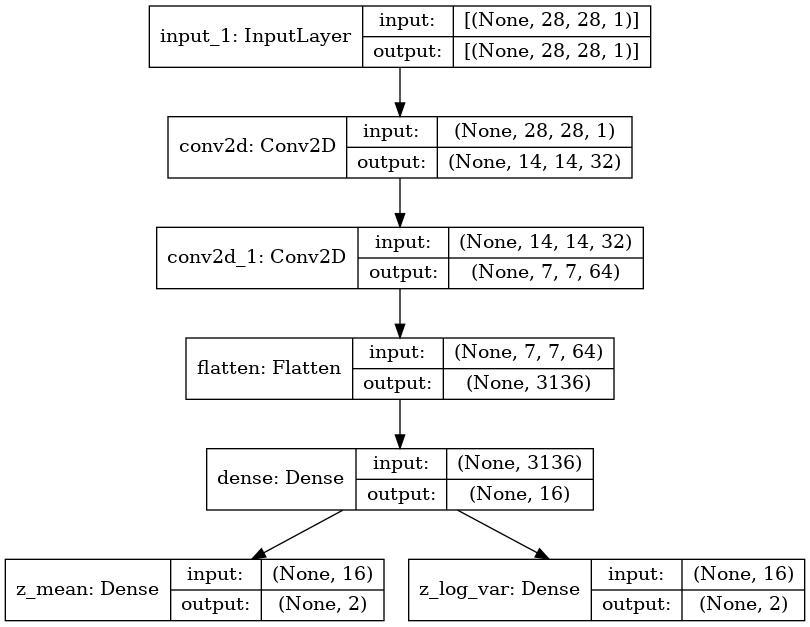

time: 443 ms (started: 2021-08-07 12:42:57 +08:00)


In [7]:
plot_model(encoder, show_shapes=True)

接下来是使用 z_mean 和 z_log_var 的代码，假设已经产生了统计分布的参数，以生成潜在空间点 。

> 清单 12.18 潜在空间采样层

In [19]:
import tensorflow as tf

class Sampler(layers.Layer):
    def call(self, z_mean, z_log_var):
        batch_size = tf.shape(z_mean)[0]
        z_size = tf.shape(z_mean)[1]
#         绘制一批随机法向量
        epsilon = tf.random.normal(shape=(batch_size, z_size)) 
        # 应用 VAE 采样公式
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

time: 872 µs (started: 2021-08-07 14:44:40 +08:00)


下面的清单显示了解码器的实现。 我们将向量重塑为图像的 z 维，然后使用几个卷积层来获得与原始 具有相同维度的最终图像输出。

> 清单12.19 VAE解码器网络，将潜在空间点映射到图像

In [20]:
# 输入我们将填入z
latent_inputs = keras.Input(shape=(latent_dim,)) 
# 产生与编码器中 Flatten 层级别相同数量的系数
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) 
# 还原编码器的图层 Flatten
x = layers.Reshape((7, 7, 64))(x)
# 还原编码器 Conv2D 的层
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x) 
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x) 
# 输出以形状 (28, 28, 1) 结束
decoder_outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x) 

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

time: 188 ms (started: 2021-08-07 14:44:45 +08:00)


它的摘要如下所示：

In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

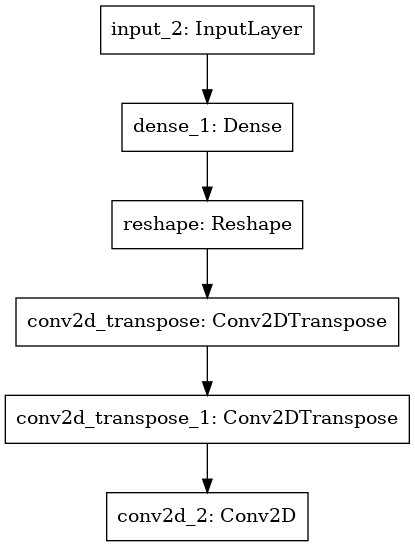

time: 862 ms (started: 2021-08-07 13:00:43 +08:00)


In [12]:
plot_model(decoder)

现在，让我们创建 VAE 模型本身。 这是不进行监督学习的模型的第一个示例（自动编码器是自监督学习的一个示例，因为它使用输入作为目标）。 每当您脱离经典的监督学习时，通常都会对类进行子类化并实现自定义模型 train_step() 来指定新的训练逻辑，这是您在第 7 章中学到的工作流程。这就是我们在这里要做的。

In [21]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.sampler = Sampler()
        
#         我们将使用这些指标来跟踪每个时期的损失平均值。
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss") 
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss") 
    
    # 我们在属性中列出了指标，以使模型能够在每个时期（或多次调用 / 之间）的指标之后重置它们。 适合评估
    @property
    def metrics(self): 
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var = self.encoder(data)
            z = self.sampler(z_mean, z_log_var)
            reconstruction = decoder(z)
            # 我们对空间维度（轴 1 和 2）上的重建损失求和，并在批量维度上取其平均值。
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(
                keras.losses.binary_crossentropy(data, reconstruction),axis=(1, 2)))
            
            # 添加正则化项（Kullback–Leibler divergence）
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) 
            total_loss = reconstruction_loss + tf.reduce_mean(kl_loss) 
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"total_loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
               }

time: 17.4 ms (started: 2021-08-07 14:44:49 +08:00)


最后，您已准备好在 MNIST 数字上实例化和训练模型。 因为损失是在自定义层中处理的，所以您在编译时没有指定外部损失 (loss=None)，这反过来意味着您不会在训练期间传递目标数据（如您所见，您只需要 在 fit() 中将 x_train 传递给模型）。

> 清单 12.21 训练 VAE

In [22]:
import numpy as np

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
# 我们在所有 MNIST 数字上进行训练，因此我们将训练和测试样本连接起来。
mnist_digits = np.concatenate([x_train, x_test], axis=0) 
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
# 请注意，我们没有在 compile() 中传递 loss 参数，因为 loss 已经是 train_step() 的一部分。
vae.compile(optimizer=keras.optimizers.Adam(), run_eagerly=True) 
# 请注意，我们没有在 fit() 中传递目标，因为 train_step() 不需要任何目标。
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 [==============================] - 43s 78ms/step - total_loss: 203.7991 - reconstruction_loss: 201.5552 - kl_loss: 2.2438
Epoch 2/30
547/547 [==============================] - 51s 93ms/step - total_loss: 163.2114 - reconstruction_loss: 160.3115 - kl_loss: 2.9000
Epoch 3/30
547/547 [==============================] - 42s 78ms/step - total_loss: 153.9748 - reconstruction_loss: 150.7013 - kl_loss: 3.2736
Epoch 5/30
547/547 [==============================] - 53s 96ms/step - total_loss: 152.1128 - reconstruction_loss: 148.7578 - kl_loss: 3.3550
Epoch 6/30
547/547 [==============================] - 45s 82ms/step - total_loss: 150.8970 - reconstruction_loss: 147.5026 - kl_loss: 3.3943 4s - total_loss: 151.
Epoch 7/30
547/547 [==============================] - 51s 93ms/step - total_loss: 149.9606 - reconstruction_loss: 146.5425 - kl_loss: 3.4181
Epoch 8/30
547/547 [==============================] - 46s 84ms/step - total_loss: 149.1412 - reconstruction_loss: 145.6782 - kl_loss

time: 23min 25s (started: 2021-08-07 14:44:51 +08:00)


一旦模型经过训练，您就可以使用网络将任意潜在空间向量解码器转换为图像。

> 清单 12.22 从 2D 潜在空间中采样点网格并将它们解码为图像

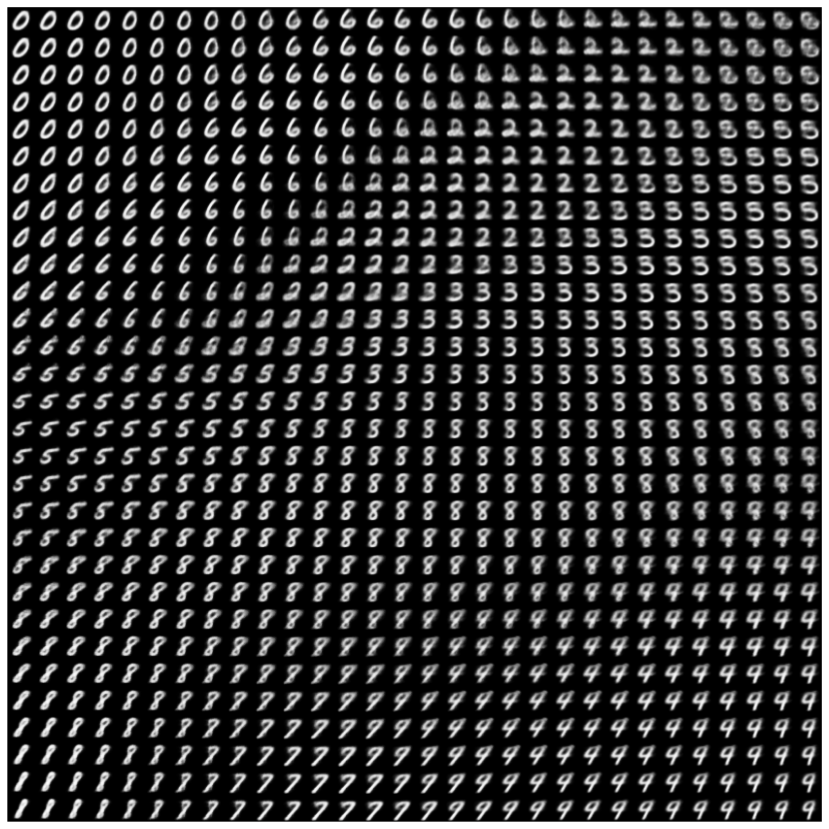

time: 1min 40s (started: 2021-08-07 15:08:17 +08:00)


In [23]:
import matplotlib.pyplot as plt

# 我们将显示一个 30 × 30 位数（总共 900 位数）的网格。
n = 30 
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 在 2D 网格上线性采样点。
grid_x = np.linspace(-1, 1, n)
grid_y = np.linspace(-1, 1, n)[::-1]

# 迭代网格位置。
for i, yi in enumerate(grid_y): 
    for j, xi in enumerate(grid_x): 
        # 对于每个位置，采样一个数字并将其添加到我们的数字中。
        z_sample = np.array([[xi, yi]]) 
        x_decoded = vae.decoder.predict(z_sample) 
        digit = x_decoded[0].reshape(digit_size, digit_size) 
        figure[i * digit_size : (i + 1) * digit_size,
               j * digit_size : (j + 1) * digit_size,
              ] = digit

plt.figure(figsize=(15, 15))
start_range = digit_size // 2
end_range = n * digit_size + start_range
pixel_range = np.arange(start_range, end_range, digit_size)
sample_range_x = np.round(grid_x, 1)
sample_range_y = np.round(grid_y, 1)
plt.xticks(pixel_range, sample_range_x)
plt.yticks(pixel_range, sample_range_y)
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.axis("off")
plt.imshow(figure, cmap="Greys_r")

采样数字网格（见图 12.18）显示了不同数字类别的完全连续分布，当你沿着一条路径穿过潜在空间时，一个数字会变成另一个数字。 这个空间中的特定方向是有含义的：例如，有“四”、“一”等的方向。

在下一节中，我们将详细介绍生成人工图像的另一个主要工具：生成对抗网络 (GAN)。

### 总结

* 使用深度学习生成图像是通过学习捕获有关图像数据集的统计信息的潜在空间来完成的。通过从潜在空间中采样和解码点，您可以生成前所未见的图像。有两个主要工具可以做到这一点：VAE 和 GAN。
* VAE 导致高度结构化、连续的潜在表示。出于这个原因，它们适用于在潜在空间中进行各种图像编辑：换脸、将皱眉的脸变成笑脸等等。它们也可以很好地用于制作基于潜在空间的动画，例如沿着潜在空间的横截面动画行走，显示起始图像以连续方式缓慢变形为不同图像。
* GAN 能够生成逼真的单帧图像，但可能不会产生具有坚实结构和高度连续性的潜在空间。

我见过的大多数成功的图像实际应用都依赖于 VAE，但 GAN 在学术研究领域一直很受欢迎。您将在下一节中了解它们的工作原理以及如何实现它们。

## 生成对抗网络简介

Goodfellow 等人于 2014 年推出的生成对抗网络 (GAN) 是 VAE 的替代方案，用于学习图像的潜在空间。 它们通过强制生成的图像在统计上与真实图像几乎无法区分，从而能够生成相当逼真的合成图像。

理解 GAN 的一种直观方式是想象一个伪造者试图创作一幅伪造的毕加索画作。 起初，伪造者的任务很糟糕。 他将他的一些赝品与真正的毕加索混合在一起，并将它们全部展示给一位艺术品经销商。 艺术品经销商对每幅画作真实性评估，并就什么使毕加索看起来像毕加索向伪造者提供反馈。 伪造者回到他的工作室准备一些新的赝品。 随着时间的推移，伪造者越来越擅长模仿毕加索的风格，而艺术品经销商也越来越擅长识别假货。 最后，他们手上有一些优秀的假毕加索。

这就是 GAN：一个伪造网络和一个专家网络，每个网络都经过训练以达到最佳效果。 因此，GAN 由两部分组成：
* 生成器网络——将随机向量（潜在空间中的随机点）作为输入，并将其解码为合成图像
* 鉴别器网络（或对手）——将图像（真实或合成）作为输入，并预测图像是来自训练集还是由生成器网络创建。

生成器网络经过训练能够欺骗鉴别器网络，因此随着训练的进行，它会朝着生成越来越逼真的图像的方向发展：看起来与真实图像无法区分的人造图像，以至于鉴别器网络不可能告诉 两个（见图 12.19）。 同时，鉴别器也在不断适应生成器逐渐提高的能力，为生成的图像设置了很高的真实性标准。 训练结束后，生成器能够将其输入空间中的任何点转换为可信图像。 与 VAE 不同，这个潜在空间对有意义结构的明确保证较少； 特别是，它不是连续的。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt886copyyj31gc0sgtch.jpg)

值得注意的是，与您在本书中遇到的任何其他训练设置不同，GAN 是一个优化最小值不固定的系统。 通常，梯度下降包括在静态损失景观中滚下山坡。 但是有了 GAN，下山的每一步都会稍微改变整个景观。 这是一个动态系统，其中优化过程不是寻求最小值，而是寻求两种力之间的平衡。 出于这个原因，众所周知，GAN 很难训练——让 GAN 工作需要对模型架构和训练参数进行大量的仔细调整。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt888j11bkj31fq0kin2y.jpg)

### GAN 实现示意图

在本节中，我们将解释如何在 Keras 中以最简单的形式实现 GAN——因为 GAN 是先进的，深入研究架构的技术细节，如生成上述图像的 StyleGAN2 的架构将超出范围 这本书。 我们将在本演示中使用的具体实现是深度卷积 GAN (DCGAN)：一个非常基本的 GAN，其中生成器和鉴别器是深度卷积网络。

我们将在来自大型 CelebFaces Attributes 数据集（称为 CelebA）的图像上训练我们的 GAN，该数据集包含 200,000 张名人面孔。 为了加快训练速度，我们将图像大小调整为 64x64，因此我们将学习生成 64x64 的人脸图像。

从原理上讲，GAN 如下所示：
* 网络将形状生成器 (latent_dim,) 的向量映射到形状 (64, 64, 3) 的图像。
* 鉴别器网络将形状为 (64, 64, 3) 的图像映射到二进制分数，估计图像是真实的概率。
* gan 网络将生成器和鉴别器链接在一起：gan(x) = discriminator(generator(x))。因此，这个 gan 网络将潜在空间向量映射到判别器对由生成器解码的这些潜在向量的真实性的评估。
* 我们使用真实和虚假图像的示例以及“真实”/“虚假”标签来训练鉴别器，就像我们训练任何常规图像分类模型一样。
* 为了训练生成器，我们使用生成器权重的梯度来考虑 gan 模型的损失。这意味着，在每一步，我们都会在一个方向上移动生成器的权重，使鉴别器更有可能将生成器解码的图像归类为“真实”图像。换句话说，我们训练生成器来欺骗鉴别器。

### 一袋套路

众所周知，训练 GAN 和调整 GAN 实现的过程非常困难。 您应该记住许多已知的技巧。 像深度学习中的大多数事情一样，它更像是炼金术而不是科学：这些技巧是启发式的，而不是有理论支持的指导方针。 它们得到了对手头现象的一定程度的直观理解的支持，并且众所周知，它们在经验上运作良好，尽管不一定适用于所有情况。

以下是本节中 GAN 生成器和鉴别器实现中使用的一些技巧。 这不是 GAN 相关技巧的详尽列表； 你会在 GAN 文献中找到更多：
* 我们在鉴别器中使用 strides 而不是池化来对特征图进行下采样——就像我们在我们的 VAE 编码器中所做的那样。
* 我们使用正态分布（高斯分布）而不是均匀分布从潜在空间中采样点。
* 随机性有利于诱导稳健性。因为 GAN 训练会导致动态平衡，所以 GAN 很可能会以各种方式卡住。在训练期间引入随机性有助于防止这种情况。我们通过向鉴别器的标签添加随机噪声来引入随机性。
* 稀疏梯度会阻碍 GAN 训练。在深度学习中，稀疏性通常是一个理想的属性，但在 GAN 中则不然。有两件事会导致梯度稀疏：最大池化操作和 ReLU 激活。我们建议使用跨步卷积进行下采样，而不是最大池化，并且我们建议使用 LeakyReLU 层而不是 ReLU 激活层。它类似于 ReLU，但它通过允许小的负激活值来放松稀疏约束。
* 在生成的图像中，经常会看到由生成器中像素空间覆盖不均引起的棋盘伪影（见图 12.21）。为了解决这个问题，每当我们在生成器和鉴别器中使用跨步 Conv2DTranpose 或 Conv2D 时，我们都会使用一个可以被步幅大小整除的内核大小。

![](https://tva1.sinaimg.cn/large/008i3skNly1gt8f5xolkpj61fu0i0gpj02.jpg)

### 获取 CelebA 数据集

您可以从网站 mmlab.ie.cuhk.edu.hk/projects/CelebA.html 手动下载数据集。 如果您使用 Colab，则只需运行以下命令即可从 Google Drive 下载数据并解压缩：

> 清单 12.23 获取 CelebA 数据

In [ ]:
# 创建工作目录
!mkdir celeba_gan
# 使用下载压缩数据（在 Colab 中默认可用，否则安装 gdown）
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
# 解压数据
!unzip -qq celeba_gan/data.zip -d celeba_gan

In [ ]:
!pip install gdown

在目录中获得未压缩的图像后，您可以使用
image_dataset_from_directory 将其转换为数据集。 由于我们只需要图像——没有标签——我们将指定 label_mode。

> 清单 12.24 从图像目录创建数据集

In [ ]:
from tensorflow import keras
dataset = keras.preprocessing.image_dataset_from_directory(
    "celeba_gan",
#     只会返回图像——没有标签。
    label_mode=None, 
    image_size=(64, 64),
    batch_size=32,
    # 我们将使用裁剪和调整大小的智能组合将图像调整为 64x64，以保持纵横比。 我们不希望面部比例被扭曲！
    smart_resize=True)

最后，让我们将图像重新缩放到 [0-1] 范围：

> 清单 12.25 重新缩放图像

In [ ]:
dataset = dataset.map(lambda x: x / 255.)

您可以使用以下代码来显示示例图像：

> 清单 12.26 显示第一张图片

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### 鉴别器

首先，您将开发一个鉴别器模型，该模型将候选图像（真实或合成）作为输入，并将其分类为两类之一：“生成的图像”或“来自训练集的真实图像”。 GAN 经常出现的许多问题之一是生成器卡住了看起来像噪声的生成图像。 一个可能的解决方案是在鉴别器中使用 dropout，这就是我们在这里要做的。

> 清单 12.27 GAN 鉴别器网络

In [12]:
from tensorflow.keras import layers
from tensorflow import keras

discriminator = keras.Sequential(
    [
    layers.InputLayer(input_shape=(64, 64, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
#     一个 dropout 层：一个重要的技巧！
    layers.Dropout(0.2), 
    layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

time: 80.4 ms (started: 2021-08-07 22:07:05 +08:00)


这是它的摘要：

In [13]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)            

In [17]:
from tensorflow.keras.utils import plot_model

time: 408 µs (started: 2021-08-07 22:15:06 +08:00)


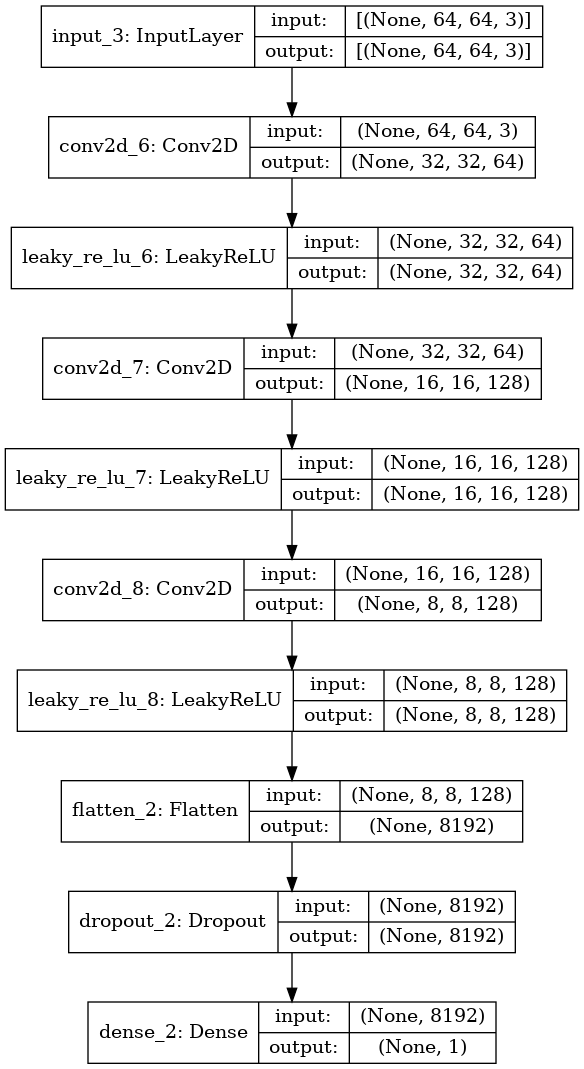

time: 294 ms (started: 2021-08-07 22:15:28 +08:00)


In [19]:
plot_model(discriminator, show_shapes=True)

### 生成器

接下来，让我们开发一个生成器模型，将向量（来自潜在空间——在训练期间将随机采样）转换为候选图像。

> 清单 12.28 GAN 生成器网络

In [15]:
# 潜在空间将由 128 维向量组成。
latent_dim = 128 

generator = keras.Sequential(
    [
        layers.InputLayer(input_shape=(latent_dim,)),
        # 产生与编码器中 Flatten 层级别相同数量的系数
        layers.Dense(8 * 8 * 128), 
        # 还原编码器的 Flatten 层
        layers.Reshape((8, 8, 128)), 
        # 恢复编码器的 Conv2D 层
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"), 
        # 我们使用作为我们的 LeakyReLU 激活
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"), 
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"), 
        layers.LeakyReLU(alpha=0.2), 
        
        # 输出以形状 (28, 28, 1) 结束
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"), 
    ],
    name="generator",
)

time: 105 ms (started: 2021-08-07 22:14:23 +08:00)


In [16]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 512)       20

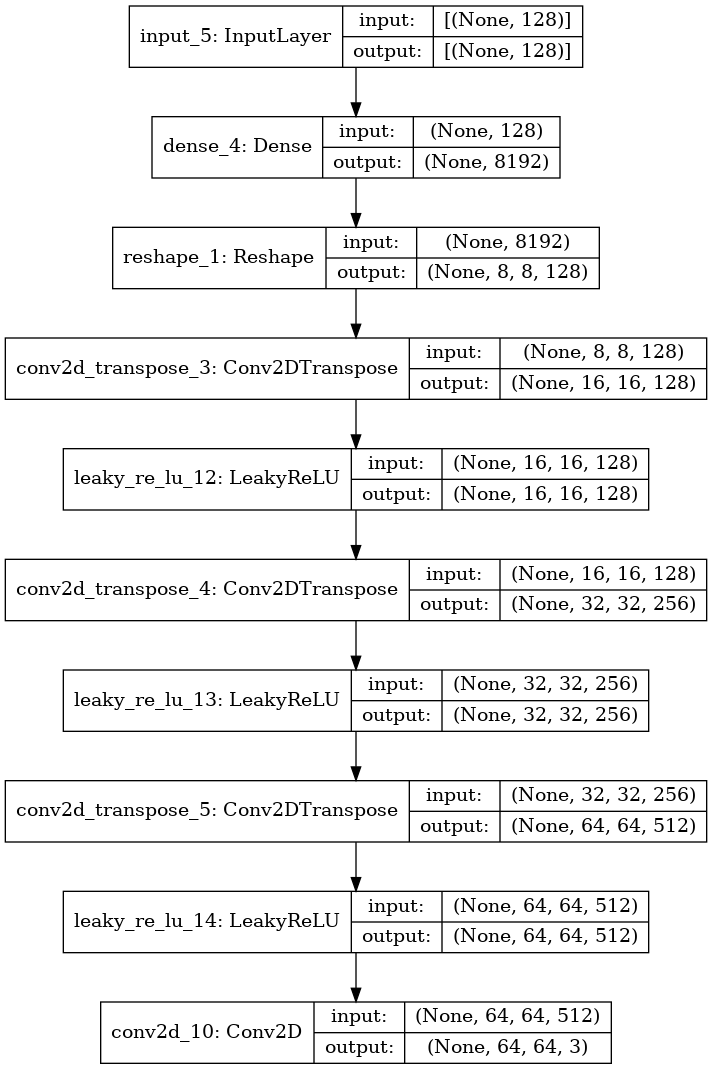

time: 341 ms (started: 2021-08-07 22:16:52 +08:00)


In [21]:
plot_model(generator, show_shapes=True)

### 对抗性网络

最后，您将设置 GAN，它将生成器和鉴别器链接起来。 训练后，该模型将使生成器朝一个方向移动，以提高其欺骗鉴别器的能力。 该模型将潜在空间点转化为分类决策——“假的”或“真实的”——并且它意味着用始终是“这些是真实图像”的标签进行训练。 因此，训练 gan 将更新生成器的权重，使鉴别器在查看假图像时更有可能预测“真实”。

概括地说，这就是训练循环的示意图。 对于每个时期，您执行以下操作：
* 在潜在空间中绘制随机点（随机噪声）。
* 使用此随机噪声通过生成器生成图像。
* 将生成的图像与真实图像混合。
* 使用这些混合图像训练鉴别器，具有相应的目标：“真实”（对于真实图像）或“假”（对于生成的图像）。
* 在潜在空间中绘制新的随机点。
* 使用这些随机向量训练生成器，目标都说“这些是真实图像”。 这会更新生成器的权重，使它们朝着让鉴别器预测生成图像的“这些是真实图像”的方向移动：这会训练生成器来欺骗鉴别器。

让我们实施它。 就像在我们的 VAE 示例中一样，我们将使用带有自定义 train_step() 的模型子类。 请注意，我们将使用两个优化器（一个用于生成器，一个用于鉴别器），因此我们还将覆盖 compile() 以允许传递两个优化器。

In [ ]:
import tensorflow as tf

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
#         设置指标来跟踪每个训练时期的两个损失
        self.d_loss_metric = keras.metrics.Mean(name="d_loss") 
        self.g_loss_metric = keras.metrics.Mean(name="g_loss") 
        
    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        
    @property
    def metrics(self): 
        return [self.d_loss_metric, self.g_loss_metric]
    
    def train_step(self, real_images):
        # 在潜在空间中采样随机点
        batch_size = tf.shape(real_images)[0] 
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) 
        
        # 将它们解码为假图像
        generated_images = self.generator(random_latent_vectors) 
        # 将它们与真实图像相结合
        combined_images = tf.concat([generated_images, real_images], axis=0)
        # 组装标签，区分真假图像
        labels = tf.concat( [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0)
        # 向标签添加随机噪声——一个重要的技巧！
        labels += 0.05 * tf.random.uniform(tf.shape(labels)) 

        
#         训练鉴别器
        with tf.GradientTape() as tape: 
            predictions = self.discriminator(combined_images) 
            d_loss = self.loss_fn(labels, predictions) 
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
        zip(grads, self.discriminator.trainable_weights) 
        )

        # 在潜在空间中采样随机点
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim)) 

        # 组装标有“这些都是真实图像”的标签（这是谎言！）
        misleading_labels = tf.zeros((batch_size, 1)) 

        # 训练生成器
        with tf.GradientTape() as tape: 
            predictions = self.discriminator(self.generator(random_latent_vectors)) 
            g_loss = self.loss_fn(misleading_labels, predictions) 
        grads = tape.gradient(g_loss, self.generator.trainable_weights) 
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights)) 

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(), "g_loss": self.g_loss_metric.result()}

在我们开始训练之前，让我们还设置一个回调来监控我们的结果：它将使用生成器在每个 epoch 结束时创建和保存一些假图像。

> 清单 12.30 在训练期间对生成的图像进行采样的回调

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
    
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

最后，我们可以开始训练：

> 清单 12.31 编译和训练 GAN

In [ ]:
epochs = 100 

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

在训练时，您可能会看到对抗性损失开始显着增加，而判别性损失趋于零——判别器最终可能会主导生成器。 如果是这种情况，请尝试降低鉴别器的学习率，并增加鉴别器的 dropout 率。

![](https://tva1.sinaimg.cn/large/008i3skNgy1gt8mkva457j31k00ogwlb.jpg)

### 总结

* GAN 由一个生成器网络和一个鉴别器网络组成。鉴别器被训练来区分生成器的输出和来自训练数据集的真实图像，而生成器被训练来欺骗鉴别器。它拥有的关于数据的信息来自鉴别器。
* GAN 很难训练，因为训练 GAN 是一个动态过程，而不是具有固定损失情况的简单梯度下降过程。使 GAN 正确训练需要使用许多启发式技巧以及广泛的调整。
* GAN 可能会产生高度逼真的图像。但与 VAE 不同的是，它们学习的潜在空间没有整齐的连续结构，因此可能不适合某些实际应用，例如通过潜在空间概念向量进行图像编辑。

这少数技术仅涵盖了这个快速扩展领域的基础知识。还有很多东西有待发现——生成式深度学习值得专门写一本书。

### 章节总结

* 您可以使用序列到序列模型来生成序列数据，一次一个步骤。 这适用于文本生成，也适用于逐个音符的音乐生成或任何其他类型的时间序列数据。
* DeepDream 的工作原理是通过输入空间中的梯度上升最大化 convnet 层激活。
* 在风格迁移算法中，内容图像和风格图像通过梯度下降组合在一起，产生具有内容图像的高级特征和风格图像的局部特征的图像。
* VAE 和 GAN 是学习图像潜在空间的模型，然后可以通过从潜在空间采样来构想全新的图像。 潜在空间中的“概念向量”甚至可以用于图像编辑。